In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize

from functools import partial
import itertools
import re

import matplotlib.gridspec as gridspec
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd
import seaborn as sns

print(__doc__)
import pandas as pd
from patsy import dmatrices
import scipy as sc
import scipy.optimize as opt
import statsmodels.api as sm

import sklearn as sk


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import TransformerMixin
from sklearn.pipeline import BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import column_or_1d
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union


from sklearn.datasets import samples_generator
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction import DictVectorizer

import sklearn.feature_extraction as fe

import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

import sklearn.linear_model as lm
import sklearn.grid_search as gs
from sklearn.svm import SVC
from sklearn.decomposition import PCA


import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cv
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn_pandas import DataFrameMapper, cross_val_score

import matplotlib.pyplot as plt
import patsy
from statsmodels.sandbox import cox

from patsylearn import *

import joblib as jb


from datasu.auc import *
from datasu.dicts import *
from datasu.files import *
from datasu.pandas import *
from datasu.persist import *

Automatically created module for IPython interactive environment


## UTILS

## LOAD DATA

In [3]:
main_folder = '/ea/Datasets/Kaggle-AcquireValuedShoppersChallenge2/'
df_coupons = pd.read_csv(main_folder+'offers')[['offer','category','company','brand','offervalue','quantity']]
df_offers_ids = pd.read_csv(main_folder+'trainHistory').rename(columns={'id': 'customer_id'})
df_offers_ids_submission = pd.read_csv(main_folder+'testHistory').rename(columns={'id': 'customer_id'})
df_trans_all = pd.read_csv(main_folder+'transactions_reduced_category').rename(columns={'id': 'customer_id'})

In [4]:
df_offers_all = pd.merge(df_offers_ids, df_coupons, on=['offer'])
df_offers_all = df_offers_all[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity','repeattrips','repeater']]

df_offers_all_submission = pd.merge(df_offers_ids_submission, df_coupons, on=['offer'])
df_offers_all_submission = df_offers_all_submission[['customer_id','chain','offer','market','category','company','brand','offerdate','offervalue','quantity']]

In [5]:
df_coupons.head()

,offer,category,company,brand,offervalue,quantity
0,1190530,9115,108500080,93904,5.00,1
1,1194044,9909,107127979,6732,1.00,1
2,1197502,3203,106414464,13474,0.75,1
3,1198271,5558,107120272,5072,1.50,1
4,1198272,5558,107120272,5072,1.50,1


In [6]:
df_coupons[df_coupons.offer==1213242]

,offer,category,company,brand,offervalue,quantity
26,1213242,5824,105190050,26456,2,1


In [7]:
df_offers_all.head()

,customer_id,chain,offer,market,category,company,brand,offerdate,offervalue,quantity,repeattrips,repeater
0,86246,205,1208251,34,2202,104460040,3718,2013-04-24,2,1,5,t
1,15753725,17,1208251,4,2202,104460040,3718,2013-04-24,2,1,0,f
2,16535563,4,1208251,1,2202,104460040,3718,2013-04-27,2,1,7,t
3,18259179,3,1208251,2,2202,104460040,3718,2013-04-24,2,1,0,f
4,21024070,15,1208251,9,2202,104460040,3718,2013-04-23,2,1,1,t


In [8]:
df_trans_all.head()

,customer_id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,99,9909,104538848,15343,2012-03-02,16.0,OZ,1,2.49
1,86246,205,58,5824,108674585,55172,2012-03-02,16.0,OZ,1,3.29
2,86246,205,72,7205,103500030,3830,2012-03-06,4.6,OZ,1,3.99
3,86246,205,55,5558,104154848,5603,2012-03-07,5.8,OZ,1,1.25
4,86246,205,58,5824,1076401474,304,2012-03-14,12.0,OZ,1,4.99


/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':
/root/.pyenv/versions/2.7.9/envs/2.7.9-analytics2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


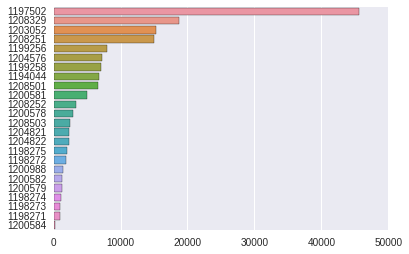

In [9]:
offer_counts = df_offers_all.groupby(by='offer').count().customer_id.order(ascending=False)
sns.barplot(y=offer_counts.index.values, x=offer_counts.values, orient='h')

## FILTER DATA

In [10]:
df_trans = df_trans_all#[0:3000000]

In [11]:
df_offers_filtered = df_offers_all#[df_offers_all.offer==1197502]

In [12]:
len(df_trans.customer_id.unique()), len(df_trans.customer_id),  len(df_offers_filtered.customer_id.unique()),len(df_offers_filtered.customer_id), 

(310665, 15349956, 160057, 160057)

## FEATURE EXTRACTION

### AGGREGATE TRANSCATIONS

In [13]:
summ_grouping = {'total':np.sum, 'average':np.average }
count_grouping = {'count':np.count_nonzero }

In [14]:
count_agg = partial(get_agg, grp_columns=['customer_id'], grouping=count_grouping)
total_avg_agg = partial(get_agg, grp_columns=['productsize','purchasequantity','purchaseamount'], grouping=summ_grouping)

In [15]:
grpby_columns = ['customer_id','brand']

df_trans_grp_customer_brand = df_trans.groupby(by=grpby_columns, axis=0) \
                               .agg(merge_dicts(count_agg(grpby_columns), \
                                                total_avg_agg(grpby_columns)))    
    
df_trans_grp_customer_brand.columns = flatten_columns(df_trans_grp_customer_brand,prefix='agg_')
df_trans_grp_customer_brand = df_trans_grp_customer_brand.reset_index()#.set_index('customer_id')
df_trans_grp_customer_brand.head()


,customer_id,brand,agg_productsize_customer_id_brand_average,agg_productsize_customer_id_brand_total,agg_customer_id_customer_id_brand_count,agg_purchaseamount_customer_id_brand_average,agg_purchaseamount_customer_id_brand_total,agg_purchasequantity_customer_id_brand_average,agg_purchasequantity_customer_id_brand_total
0,86246,304,12,36,3,5.156667,15.47,1.000000,3
1,86246,305,6,18,3,1.650000,4.95,1.666667,5
2,86246,330,20,60,3,1.923333,5.77,1.000000,3
3,86246,401,50,50,1,6.590000,6.59,1.000000,1
4,86246,867,44,220,5,1.728000,8.64,1.200000,6


In [16]:
print len(df_trans_grp_customer_brand.brand.unique())
print len(df_trans_grp_customer_brand)

1881
4182530


In [17]:
grpby_columns = ['customer_id','category']
grp_columns = ['purchaseamount']

df_trans_grp_customer_category = df_trans.groupby(by=grpby_columns, axis=0) \
                                         .agg(merge_dicts(count_agg(grpby_columns), \
                                              total_avg_agg(grpby_columns))) 
    
df_trans_grp_customer_category.columns = flatten_columns(df_trans_grp_customer_category, prefix='agg_')
df_trans_grp_customer_category = df_trans_grp_customer_category.reset_index()#.set_index('customer_id')
df_trans_grp_customer_category.head()



,customer_id,category,agg_productsize_customer_id_category_total,agg_productsize_customer_id_category_average,agg_customer_id_customer_id_category_count,agg_purchaseamount_customer_id_category_total,agg_purchaseamount_customer_id_category_average,agg_purchasequantity_customer_id_category_total,agg_purchasequantity_customer_id_category_average
0,86246,706,441.0,49.000000,9,37.38,4.153333,10,1.111111
1,86246,1703,470.5,31.366667,15,57.64,3.842667,18,1.200000
2,86246,1726,230.0,57.500000,4,12.18,3.045000,4,1.000000
3,86246,2119,1224.6,43.735714,28,63.66,2.273571,38,1.357143
4,86246,3203,79.0,5.266667,15,41.66,2.777333,15,1.000000


In [18]:
print len(df_trans_grp_customer_category)

2402099


In [19]:
grpby_columns = ['customer_id','dept']
grp_columns = ['productsize','purchaseamount']

df_trans_grp_customer_dept = df_trans.groupby(by=grpby_columns, axis=0) \
                                     .agg(merge_dicts(count_agg(grpby_columns), \
                                          total_avg_agg(grpby_columns))) 
    
df_trans_grp_customer_dept.columns = flatten_columns(df_trans_grp_customer_dept, prefix='agg_')
df_trans_grp_customer_dept = df_trans_grp_customer_dept.reset_index()#.set_index('customer_id')
df_trans_grp_customer_dept.head()

,customer_id,dept,agg_productsize_customer_id_dept_average,agg_productsize_customer_id_dept_total,agg_customer_id_customer_id_dept_count,agg_purchaseamount_customer_id_dept_average,agg_purchaseamount_customer_id_dept_total,agg_purchasequantity_customer_id_dept_average,agg_purchasequantity_customer_id_dept_total
0,86246,7,49.000000,441.00,9,4.153333,37.38,1.111111,10
1,86246,17,36.868421,700.50,19,3.674737,69.82,1.157895,22
2,86246,21,43.735714,1224.60,28,2.273571,63.66,1.357143,38
3,86246,32,5.266667,79.00,15,2.777333,41.66,1.000000,15
4,86246,35,39.182941,3996.66,102,3.289706,335.55,1.333333,136


### PERSIST DATA TO DISK

In [ ]:
persist_variables(['df_trans_grp_customer_brand',
                   'df_trans_grp_customer_category',
                   'df_trans_grp_customer_dept']
                  ,path=main_folder+'working_data')